# *Nov 24 monthly Demo - Runge*

This notebook contains all of the code used to produce the results and figures included in the paper

### Load dependencies

In [5]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [69]:
scenario_3_total_popp =100000 # US Census Bureau
initial_vacc = 0
initial_hosp = 0
initial_recovered = 0
initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 99900
initial_ccases = 0
initial_chosp = 0

# Model derivation and initialization

### Define units

In [70]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [71]:
c = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'V': Concept(name="V", units=person_units()),  # Vaccinated
    'I': Concept(name='I', units=person_units()),  # Infectious
    'R': Concept(name='R', units=person_units()),  # Recovered
    'H': Concept(name="H", units=person_units()),  # Hospitalized
    'D': Concept(name="D", units=person_units()),  # Deceased
    'C_c': Concept(name="C_c", units=person_units()),  # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units())  # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept


### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [72]:

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.6), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp), units=person_units()),  
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Vaccination rate
    'sigma': Parameter(name='sigma', value=sympy.Float(0.10), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'epsilon': Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units()),  # Rate exposed and vaccinated individuals become infected
    'delta': Parameter(name='delta', value=sympy.Float(0.05), units=per_day_units()),  # Rate infected individuals recover
    'gamma': Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units()),  # Rate infected individuals become hospitalized
    'alpha': Parameter(name='alpha', value=sympy.Float(0.01), units=per_day_units()),  # Death rate for infected individuals who are not hospitalized
    'rho': Parameter(name='rho', value=sympy.Float(0.10), units=per_day_units()),  # Rate hospitalized individuals recover
    'mu': Parameter(name='mu', value=sympy.Float(0.02), units=per_day_units()),  # Death rate for hospitalized individuals
}

parameters_q1 = parameters.copy()
parameters_q1['epsilon'] = Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.05,
                                                            'maximum': 1.5*0.05}))
parameters_q1['gamma'] = Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.02,
                                                            'maximum': 1.5*0.02}))


### Define `SymPy` variables

In [73]:
S, E, I, R, H, V, D,  C_c, C_h, beta, N, nu, sigma, epsilon, delta, gamma, alpha, rho, mu = sympy.symbols('S E I R H V D C_c C_h beta N nu sigma epsilon delta gamma alpha rho mu')

### Set initial conditions

In [74]:

initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_infected),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [75]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


##### V - E # even though the diagram doesn't have V -> E, the equation does include V*I/N to calculate Exposed
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=epsilon*V*I / N
)


# S -> V
rv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=nu*S
)

#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=delta*I # not r_IR*(1 - r_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=gamma*I # not r_IR*r_IH*I as in previous model
)

#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=alpha*I
)

#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=rho*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=mu*H
)


### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=gamma*I # instead of r_IR*r_IH*I as orignal due to being a different model (i guess)
)

# List of all transitions
transitions = [se, ve, rv, ei, ir, ih, id, hr, hd, ccases, chosp]




### Define observables

In [76]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [ ]:
model1 = "scenerio_3_mo.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model1, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

### 4.1 Sensitivity Analysis

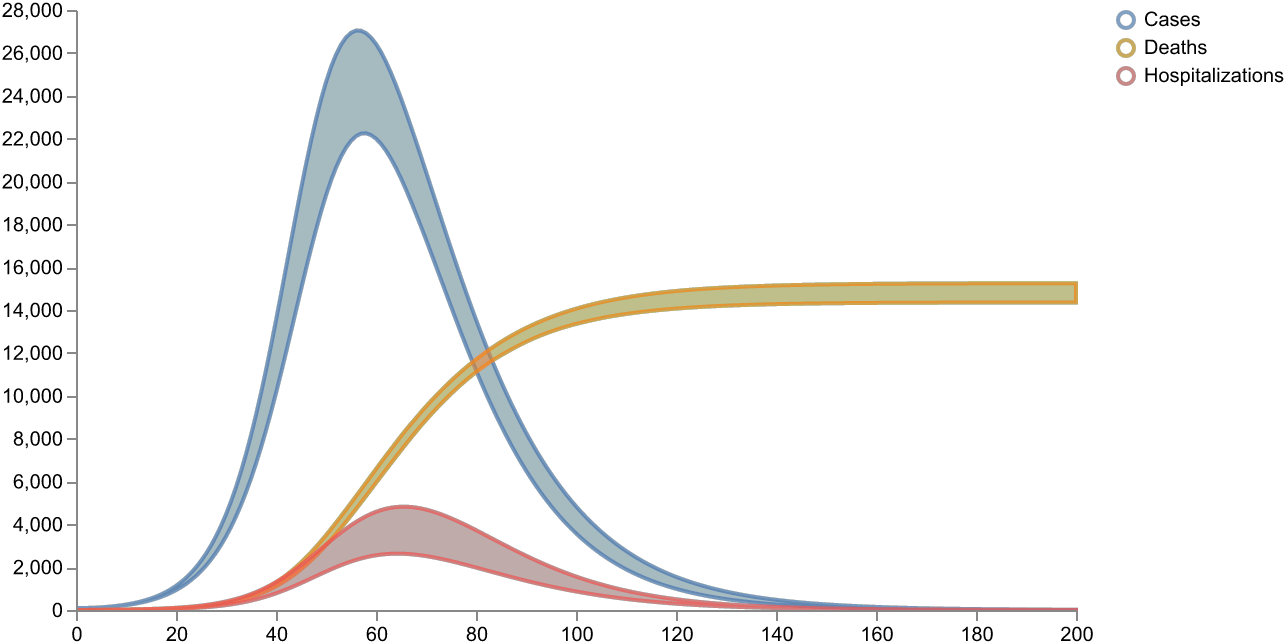

In [79]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### 4.2 Decision Maker


In [ ]:
# 𝛼 (alpha) r_ID  = 0.01 / 𝑑𝑎𝑦 is the death rate for infected individuals who are not hospitalized
# 𝛽 (beta) r_SE= 0.60 new infections per infected person/day is the transmission rate
# 𝛿 (delta) r_IR= 0.05 / 𝑑𝑎𝑦 is the rate infected individuals recover
# 𝜖 (epsilon) r_VE (I think the diagram in pdf is wrong V goes to E, not I based on the equations)= 0.05 / 𝑑𝑎𝑦 is the rate exposed and vaccinated individuals become infected
# 𝛾 (gamma) r_IH = 0.02 / 𝑑𝑎𝑦 is the rate infected individuals become hospitalized
# 𝜇 (mu) r_HD = 0.02 / 𝑑𝑎𝑦 is the death rate for hospitalized individuals
# 𝜈 (nu) r_SV = 0.005 / 𝑑𝑎𝑦 is the vaccination rate
# 𝜌 (rho) r_HR = 0.10 / 𝑑𝑎𝑦 is the rate hospitalized individuals recover
# 𝜎 (sigma) r_EI = 0.10 / 𝑑𝑎𝑦 is the rate exposed and unvaccinated individuals become infected

In [80]:
static_parameter_interventions_opt_1 = {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}}
static_parameter_interventions_opt_2 = {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}}
static_parameter_interventions_opt_3 = {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}}
static_parameter_interventions_opt_4 = {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}

In [ ]:
model_intervention = "scenerio_3_mo_intervention.json"
start_time = 0.0
end_time = 200.0
interventions = [
    static_parameter_interventions_opt_1,
    static_parameter_interventions_opt_2,
    static_parameter_interventions_opt_3,
    static_parameter_interventions_opt_4
]
seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


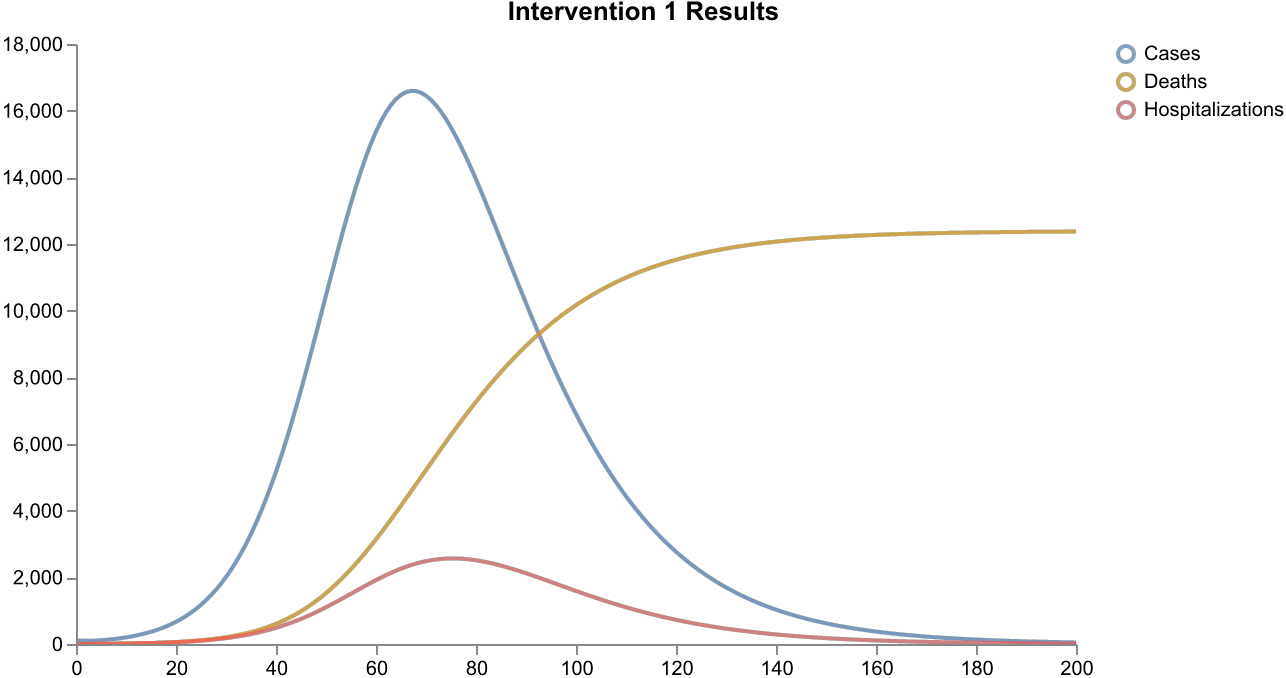

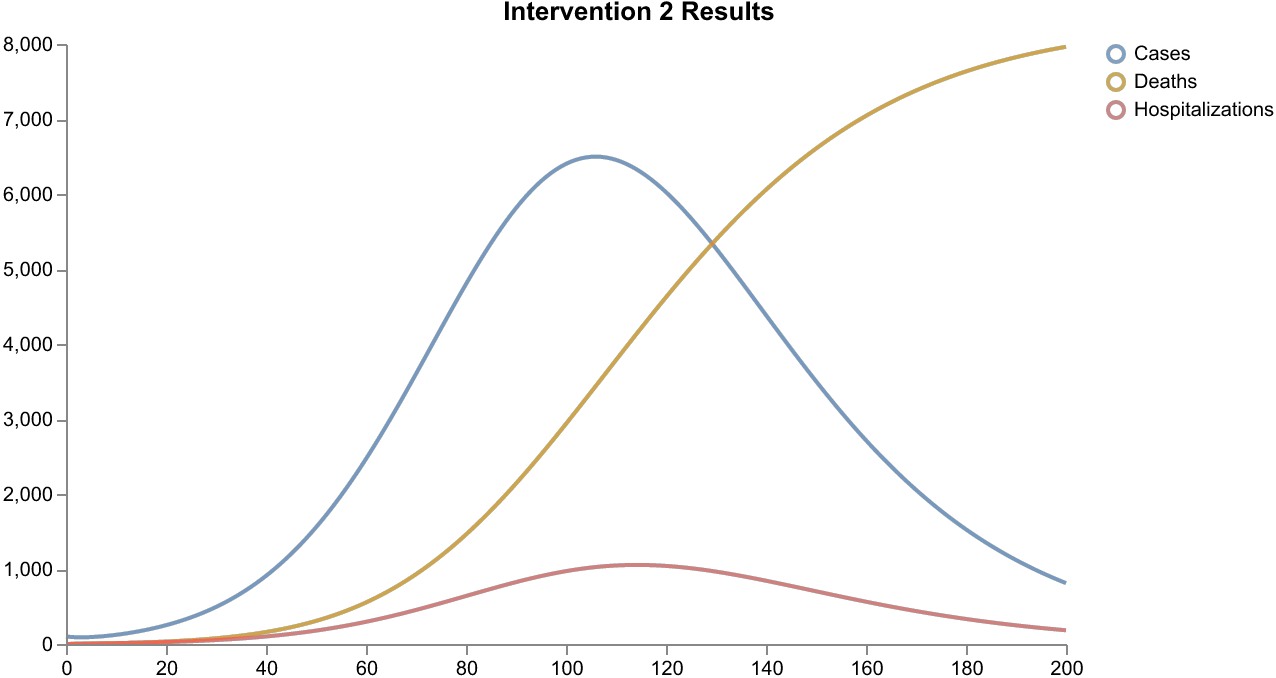

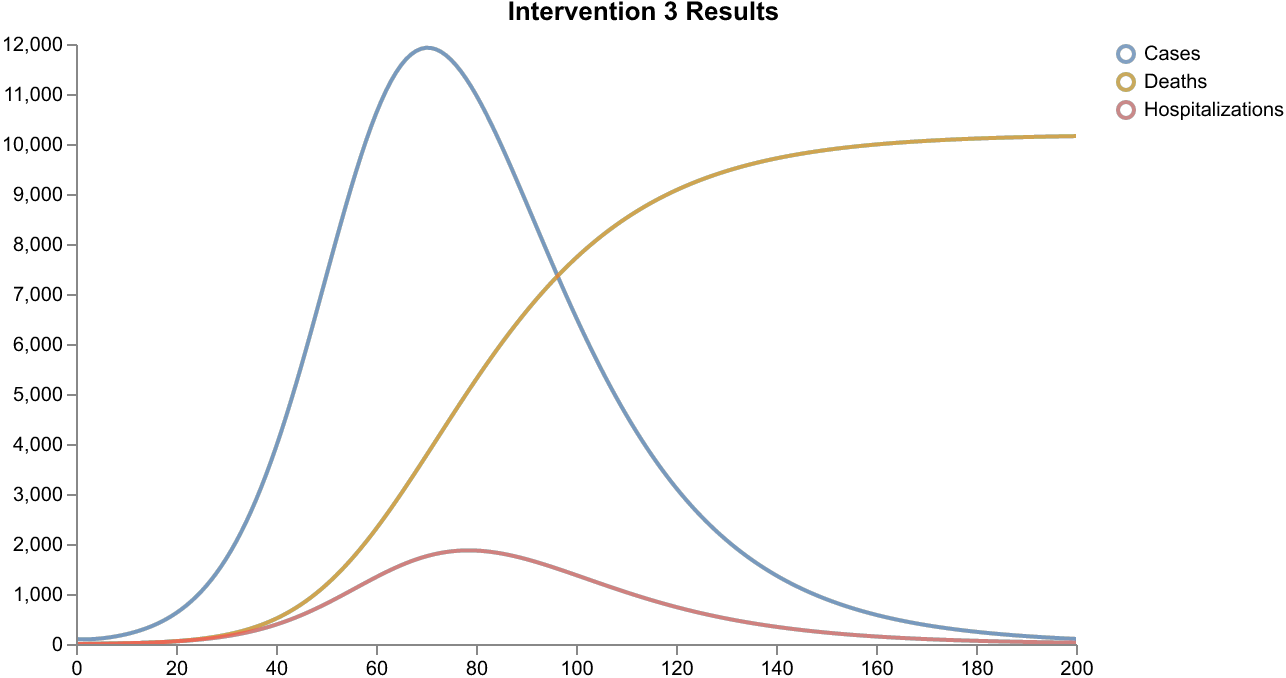

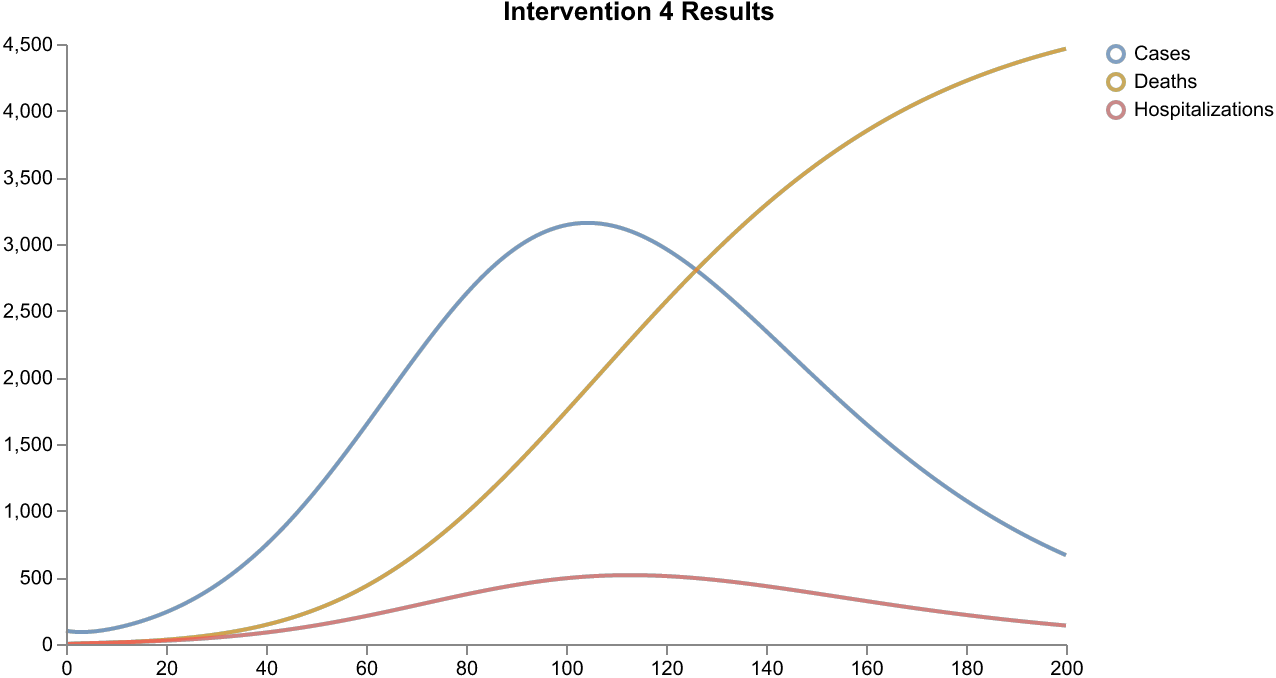

In [ ]:

for i, intervention in enumerate(interventions):
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)

    # Plot results for all states
    nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
    }

    schema = plots.trajectories(
        invervention_sample_results["data"], 
        keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
        relabel=nice_labels,
        title=f"Intervention {i+1} Results"
    )
    plots.save_schema(schema, f"_schema_intervention_{i+1}.json")
    display(plots.ipy_display(schema, dpi=150))

### 4.3 Decision Maker + Uncertainity at 50 days



In [ ]:
model_intervention = "scenerio_3_mo_intervention_uncertainity.json"
start_time = 0.0
end_time = 50.0
interventions = [
    static_parameter_interventions_opt_1,
    static_parameter_interventions_opt_2,
    static_parameter_interventions_opt_3,
    static_parameter_interventions_opt_4
]
seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


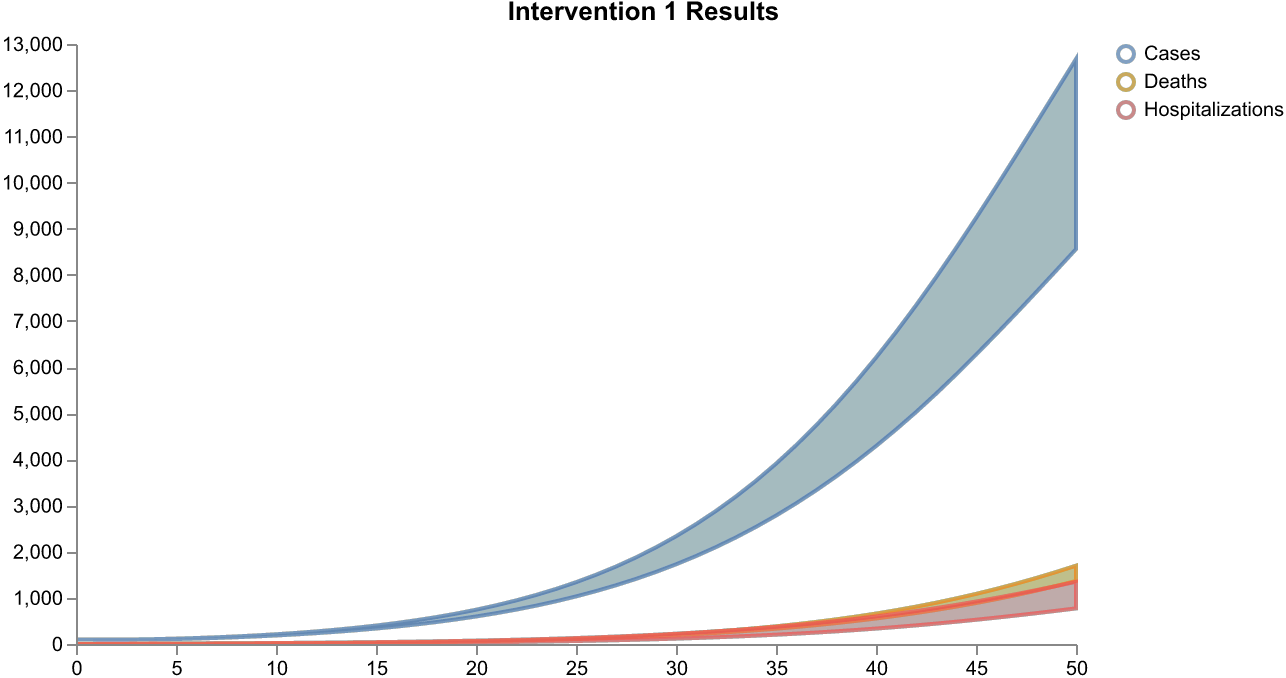

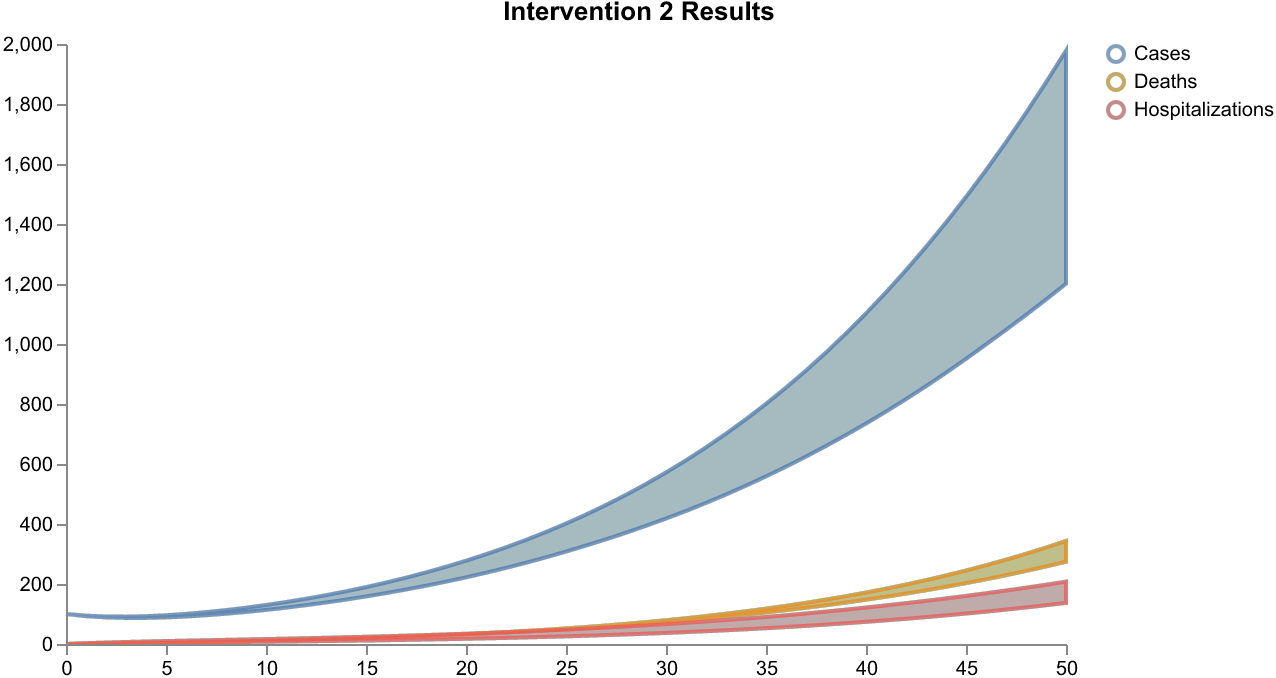

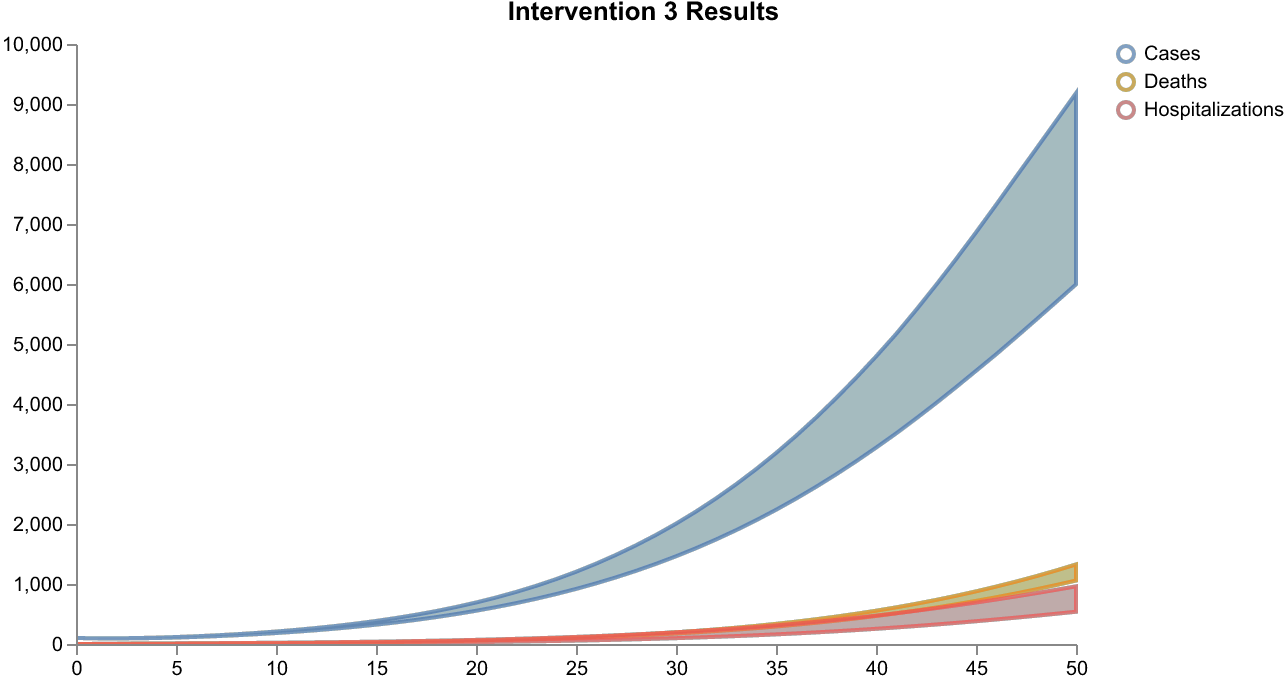

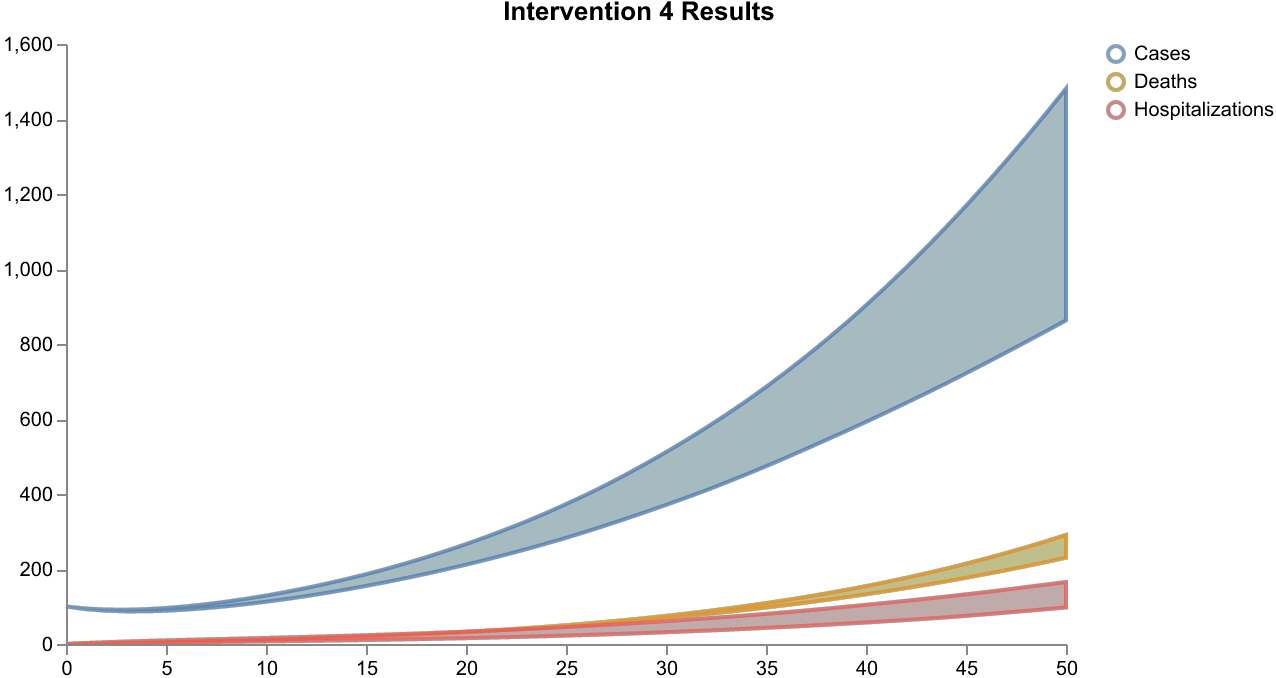

In [ ]:

for i, intervention in enumerate(interventions):
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)

    # Plot results for all states
    nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
    }

    schema = plots.trajectories(
        invervention_sample_results["data"], 
        keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
        relabel=nice_labels,
        title=f"Intervention {i+1} Results"
    )
    plots.save_schema(schema, f"_schema_intervention_{i+1}.json")
    display(plots.ipy_display(schema, dpi=150))

### 4.4 Horizon Scanning Maker


In [99]:
scenario_3_total_popp_seid =800000 # US Census Bureau

initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 79900
initial_ccases = 0


In [100]:
c_seid = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'I': Concept(name='I', units=person_units()),  # Infectious
    'D': Concept(name='D', units=person_units()),  # Recovered
    'C_c': Concept(name="C_c", units=person_units())  # Cumulative Cases
}

for concept in c_seid:
    c_seid[concept].name = concept


In [101]:
parameters_seid = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .2,
                                                            'maximum': .8})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .05,
                                                            'maximum': .1})),  # Death rate for hospitalized individuals
}


In [102]:

initials_seid = {
    "S": Initial(concept=c_seid["S"], expression=initial_susceptible),
    "E": Initial(concept=c_seid["E"], expression=initial_exposed),
    "I": Initial(concept=c_seid["I"], expression=initial_infected),
    "D": Initial(concept=c_seid["D"], expression=initial_deaths),
    "C_c": Initial(concept=c_seid["C_c"], expression=initial_ccases),
}


In [103]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)




#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=mu*I
)



### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)


# List of all transitions
transitions_seid = [se, ei, id, ccases]



In [104]:
observables_seid = {
    'cases': Observable(name='cases', expression=I),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c)
}

In [105]:
model_seid = "scenerio_3_mo_seid.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

# Save as JSON
with open(model_seid, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

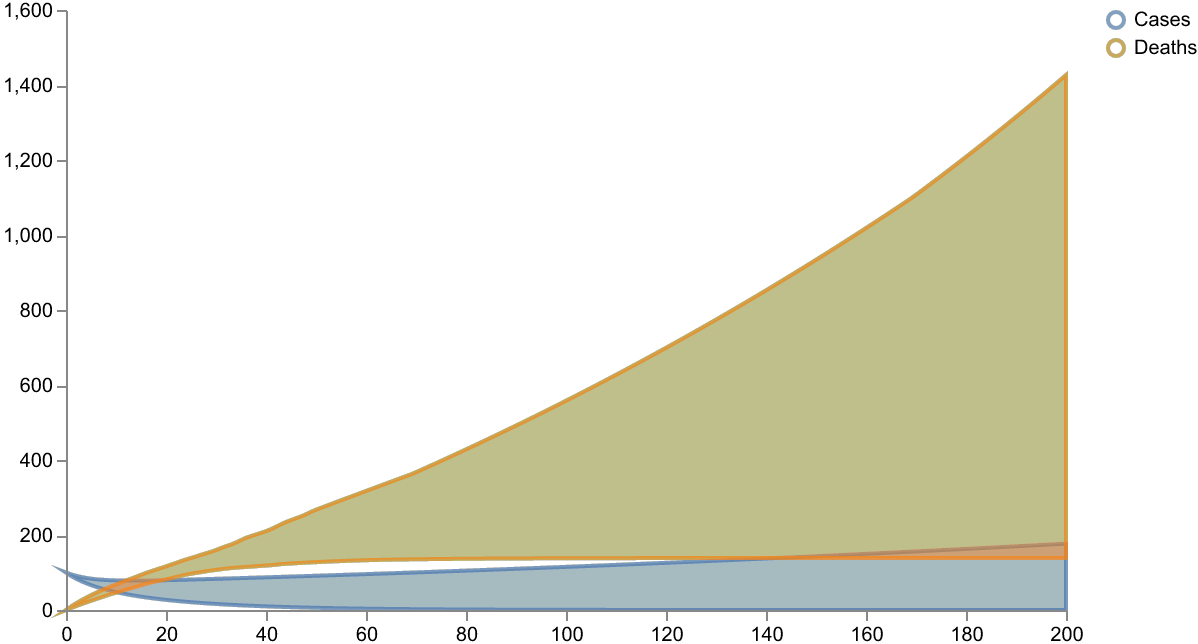

In [106]:
result1 = pyciemss.sample(model_seid, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)